In [3]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import mir_eval
import IPython.display
import librosa.display as librosa_display
import impyute
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from clusterer import Clusterer
from visualizers import vis_spec

# Ground-Truth Cluster + Outliers

Load checkpoints

In [4]:
def load_checkpoint(path:str) -> np.ndarray:
    arr:np.ndarray = None
    with open(path, 'rb') as f:
        arr = np.load(f)
    return arr

In [5]:
# G_full:np.ndarray = load_checkpoint('checkpoints/G_full.pkl')
G_foreground:np.ndarray = load_checkpoint('checkpoints/validation/G_foreground.pkl')
G_fg_mask:np.ndarray = load_checkpoint('checkpoints/validation/G_fg_mask.pkl')
    
print(G_foreground[:2])
print(G_foreground.shape)

[[1.3633264e-04 1.5644377e-04 9.6360942e-05 ... 1.2095691e-04
  7.4529533e-05 3.4585275e-05]
 [2.6717625e-04 1.2073835e-04 1.7027929e-05 ... 1.8443799e-05
  1.0868744e-05 3.0635968e-06]]
(128, 611)


Initialize clusterer

In [6]:
G_clusterer:Clusterer = Clusterer(G_foreground.T, [f'm-{i}' for i in range(0,128)])

Preview features

In [7]:
G_df = pd.DataFrame(G_foreground.T, columns=[f'm-{i}' for i in range(0,128)])
G_df[:2].head()

m-0       m-1       m-2       m-3       m-4       m-5       m-6  \
0  0.000136  0.000267  0.000031  0.000002  0.000003  0.000004  0.000004   
1  0.000156  0.000121  0.000046  0.000017  0.000010  0.000003  0.000006   

        m-7       m-8       m-9  ...         m-118         m-119  \
0  0.000010  0.000003  0.000003  ...  9.948181e-08  1.881611e-07   
1  0.000011  0.000003  0.000004  ...  1.194362e-07  1.886237e-07   

          m-120         m-121         m-122         m-123         m-124  \
0  1.630398e-07  2.537769e-07  3.353193e-07  3.256963e-07  4.094204e-07   
1  1.659041e-07  2.531312e-07  3.870909e-07  3.377040e-07  4.704962e-07   

          m-125         m-126         m-127  
0  5.263209e-07  7.087176e-07  7.452984e-07  
1  5.879905e-07  6.989778e-07  6.807432e-07  

[2 rows x 128 columns]

Establish K with Kmeans

In [8]:
def search_param(method:callable, key:str, mn:int=2, mx:int=9, params:dict={}) -> int:
    ks:list = []
    for k in range(mn, mx):
        try:
            params.update({key: k})
            sil_score = method(params)
            ks.append((k, sil_score))
            # print((k, sil_score))
        except:
            break
    
    best:list = sorted(ks, key=lambda tup: tup[1], reverse=True)
    
    val, _ = best[0]
    
    #print('best: ', _, val)
    
    return val

In [9]:
G_k = search_param(G_clusterer.apply_kmeans, 'n_clusters', mn=2, mx=20)
G_km_SilScore = G_clusterer.apply_kmeans({'n_clusters': G_k})
G_kmeans = G_clusterer.kmeans
G_km_labels:list = G_kmeans.labels_
    
print('Labels:', np.unique(G_km_labels, return_counts=True))
print('Silhouette Score:', G_km_SilScore)
print('Best K:', G_k)

Labels: (array([0, 1], dtype=int32), array([ 90, 521]))
Silhouette Score: 0.6493307
Best K: 2


In [10]:
def vis_clusters(original, 
                 clusters:list, 
                 xlim:tuple=(-1,1), 
                 ylim:tuple=(-1,1),
                 title:str='',
                 colors:list=None,
                 split:bool=False,
                 split_titles:list=None):
    
    colors:list = colors or ['c','m','b', 'g', 'r', 'y', 'k', 'w']
    
    if split:
        fig, axs = plt.subplots(1,len(clusters), figsize=(15, 3), facecolor='w', edgecolor='k')
        fig.subplots_adjust(hspace =.5, wspace=.5)
        axs = axs.ravel()
    
    for i, cl in enumerate(clusters):   
        
        obj = axs[i] if split else plt
        obj.scatter(original[cl][:, 0], original[cl][:, 1], s=50, c=colors[i], alpha=.25);
        
        if split:
            obj.set_xlim(*xlim)
            obj.set_ylim(*ylim)
            if split_titles and len(split_titles) == len(clusters):
                obj.set_title(split_titles[i])
        else:
            plt.xlim(*xlim)
            plt.ylim(*ylim)
    
    if not split:
        plt.title(title)

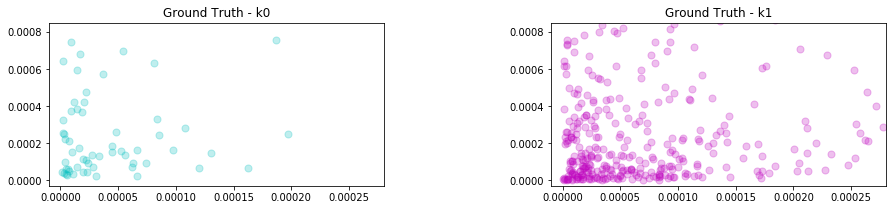

In [11]:
G_primary_cluster:np.ndarray = np.where(G_km_labels == 0)[0]
G_secondary_cluster:np.ndarray = np.where(G_km_labels == 1)[0]

G_clusters:list = [
    G_primary_cluster,
    G_secondary_cluster
]

vis_clusters(G_foreground.T, 
             G_clusters, 
             xlim=(-.00001, .00028),
             ylim=(-.00003, .00085),
             split_titles=['Ground Truth - k0', 'Ground Truth - k1'],
             split=True)

Find outliers with DBSCAN

In [12]:
G_min_cluster_size:int = search_param(G_clusterer.apply_hdbscan, 
                                      'min_cluster_size', 
                                       mn=2, mx=100, 
                                       params={})

In [13]:
G_min_samples:int = search_param(G_clusterer.apply_hdbscan,
                                 'min_samples', 
                                 mn=2, mx=100,
                                 params={'min_cluster_size': G_min_cluster_size})

Since hdbscan supports sparse clusters, we should expect to arrive at more than 2

In [14]:
G_hdb_SilScore:float = G_clusterer.apply_hdbscan({ # euclidean distance
    'min_cluster_size':G_min_cluster_size,
    'min_samples': G_min_samples,
    'allow_single_cluster': True
})
G_hdb_labels:tuple = G_clusterer.hdbscan.labels_
print('Best K:', len(np.unique(G_hdb_labels)))
print('Optimal min_cluster_size:', G_min_cluster_size)
print('Optimal min_samples:', G_min_samples)
print('Labels:', np.unique(G_hdb_labels, return_counts=True))
print('Silhouette Score:', G_hdb_SilScore)

Best K: 5
Optimal min_cluster_size: 7
Optimal min_samples: 2
Labels: (array([-1,  0,  1,  2,  3]), array([320,  11,  13, 257,  10]))
Silhouette Score: 0.113444425


HDBSCAN Clusters

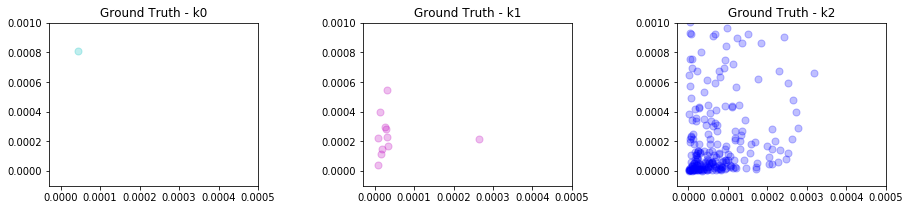

In [15]:
G_1_cluster:np.ndarray = np.where(G_hdb_labels == 0)[0]
G_2_cluster:np.ndarray = np.where(G_hdb_labels == 1)[0]
G_3_cluster:np.ndarray = np.where(G_hdb_labels == 2)[0]

G_clusters:list = [
    G_1_cluster,
    G_2_cluster,
    G_3_cluster,
]

vis_clusters(G_foreground.T, 
             G_clusters,
             xlim=(-.00003, .0005),
             ylim=(-.0001, .001),
             split_titles=['Ground Truth - k0', 'Ground Truth - k1', 'Ground Truth - k2'],
             split=True,)

Establish baseline for outliers

In [16]:
G_outlier_scores:np.ndarray = G_clusterer.hdbscan.outlier_scores_
G_outlier_scores[:5]

array([0.6272274 , 0.39547116, 0.12102295, 0.51592695, 0.55729902])

Text(0.5, 1.0, 'Outliers Distribution - Ground Truth')

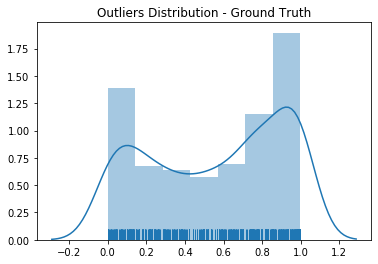

In [17]:
sns.distplot(G_outlier_scores[np.isfinite(G_outlier_scores)], 
             rug=True,)
plt.title("Outliers Distribution - Ground Truth")

In [18]:
G_threshold:np.ndarray = pd.Series(G_outlier_scores).quantile(.9)
G_outliers:np.ndarray = np.where(G_outlier_scores > G_threshold)[0]
print(f'Total Scores > {G_threshold} = {len(G_outliers)}')

Total Scores > 0.9930413605890515 = 59


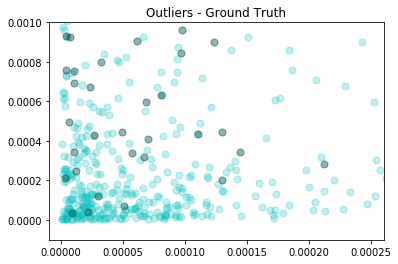

In [19]:
G_fg_bool:np.ndarray = np.ones(G_outlier_scores.shape, dtype=bool)
vis_clusters(G_foreground.T, [G_fg_bool, G_outliers],
             xlim=(-.00001, .00026),
             ylim=(-.0001, .001),
             title='Outliers - Ground Truth',
             colors=['c','k'])

In [20]:
def reconstruct_from_slice(Mel, indices):
    return Mel.T[indices].T

In [21]:
def audio_to_onset(audio:np.ndarray, sr:int) -> tuple:
    frames:np.ndarray = librosa.onset.onset_detect(audio, sr=sr, delta=0., wait=25)
    times:np.ndarray = librosa.frames_to_time(frames, sr=sr)
    samples:np.ndarray = librosa.frames_to_samples(frames)
        
    return (frames, times, samples)

In [22]:
def audio_with_beeps(M:np.ndarray, sr:int, length:float=None) -> tuple:
    audio:np.ndarray = librosa.feature.inverse.mel_to_audio(M, sr=sr,)
    length = length or audio.size
    _, onset_times, _ = audio_to_onset(audio, sr=sr)
    beeps:np.ndarray = mir_eval.sonify.clicks(onset_times, sr, length=length)
    
    return (audio, beeps)

# Damaged Clustering and Outliers

In [23]:
D_foreground:np.ndarray = load_checkpoint('checkpoints/validation/D_foreground.pkl')
D_fg_mask:np.ndarray = load_checkpoint('checkpoints/validation/D_fg_mask.pkl')

print(D_foreground[:2])
print(D_foreground.shape)

[[6.7574710e-11 3.6366637e-10 4.8832571e-10 ... 7.6135453e-05
  5.0720402e-05 3.0889401e-05]
 [2.4170949e-10 5.9775890e-10 5.7097715e-10 ... 6.6624358e-05
  8.2739076e-05 6.1160645e-05]]
(128, 682)


Initialize clusterer

In [24]:
D_clusterer:Clusterer = Clusterer(D_foreground.T, [f'm-{i}' for i in range(0,128)])

In [25]:
D_k = search_param(D_clusterer.apply_kmeans, 'n_clusters', mn=2, mx=20,)
D_km_SilScore = D_clusterer.apply_kmeans({'n_clusters': D_k})
D_kmeans = D_clusterer.kmeans
D_km_labels:list = D_kmeans.labels_
    
print('labels:', np.unique(D_km_labels, return_counts=True))
print('silhouette score:', D_km_SilScore)
print('Best K:', D_k)

labels: (array([0, 1, 2], dtype=int32), array([105, 559,  18]))
silhouette score: 0.66890615
Best K: 3


K-Means Clusters

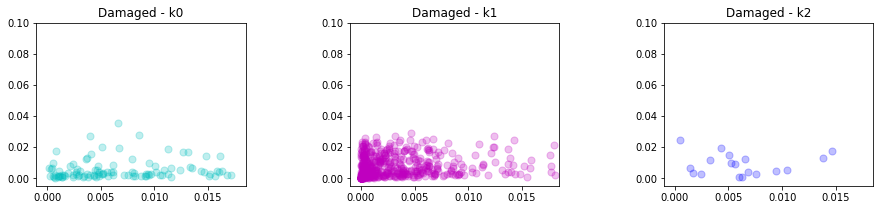

In [26]:
D_1_cluster:np.ndarray = np.where(D_km_labels == 0)[0]
D_2_cluster:np.ndarray = np.where(D_km_labels == 1)[0]
D_3_cluster:np.ndarray = np.where(D_km_labels == 2)[0]

D_clusters:list = [
    D_1_cluster,
    D_2_cluster,
    D_3_cluster,
]

# print(D_foreground.T.min(), D_foreground.T.max())

vis_clusters(D_foreground.T, 
             D_clusters,
             xlim=(-.001, .0185),
             ylim=(-.005, .1),
             split_titles=['Damaged - k0', 'Damaged - k1', 'Damaged - k2'],
             split=True,)

Find outliers with DBSCAN

In [27]:
D_min_cluster_size:int = search_param(D_clusterer.apply_hdbscan, 
                                      'min_cluster_size', 
                                       mn=2, mx=100, 
                                       params={})

In [28]:
D_min_samples:int = search_param(D_clusterer.apply_hdbscan,
                                 'min_samples', 
                                 mn=2, mx=100,
                                 params={'min_cluster_size': D_min_cluster_size})

In [29]:
D_hdb_SilScore:float = D_clusterer.apply_hdbscan({ # euclidean distance
    'min_cluster_size':D_min_cluster_size,
    'min_samples': D_min_samples,
    'allow_single_cluster': True
})
D_hdb_labels:tuple = D_clusterer.hdbscan.labels_
print('Best K:', len(np.unique(D_hdb_labels)))
print('Optimal min_cluster_size:', D_min_cluster_size)
print('Optimal min_samples:', D_min_samples)
print('Labels:', np.unique(D_hdb_labels, return_counts=True))
print('Silhouette Score:', D_hdb_SilScore)

Best K: 3
Optimal min_cluster_size: 8
Optimal min_samples: 8
Labels: (array([-1,  0,  1]), array([144, 529,   9]))
Silhouette Score: 0.54967356


HBDSCAN Clusters

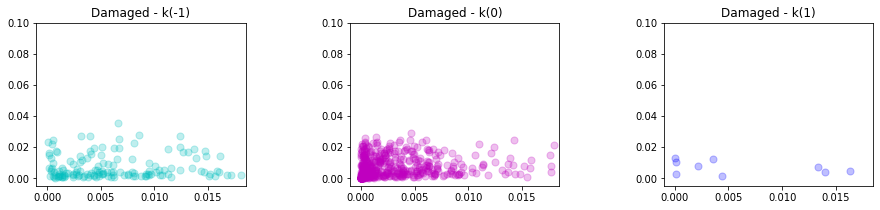

In [30]:
D_1_cluster:np.ndarray = np.where(D_hdb_labels == -1)[0]
D_2_cluster:np.ndarray = np.where(D_hdb_labels == 0)[0]
D_3_cluster:np.ndarray = np.where(D_hdb_labels == 1)[0]

D_clusters:list = [
    D_1_cluster,
    D_2_cluster,
    D_3_cluster,
]

# print(D_foreground.T.min(), D_foreground.T.max())

vis_clusters(D_foreground.T, 
             D_clusters,
             xlim=(-.001, .0185),
             ylim=(-.005, .1),
             split_titles=['Damaged - k(-1)', 'Damaged - k(0)', 'Damaged - k(1)'],
             split=True,)

In [31]:
D_outlier_scores:np.ndarray = D_clusterer.hdbscan.outlier_scores_
D_outlier_scores[:5]

array([0.48755347, 0.2060233 , 0.        , 0.21011585, 0.        ])

Text(0.5, 1.0, 'Outliers Distribution - Damaged Sample')

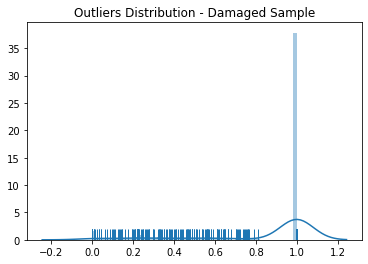

In [32]:
sns.distplot(D_outlier_scores[np.isfinite(D_outlier_scores)], 
             rug=True,)
plt.title("Outliers Distribution - Damaged Sample")

In [33]:
D_threshold:np.ndarray = pd.Series(D_outlier_scores).quantile(.9)
D_outliers:np.ndarray = np.where(D_outlier_scores > D_threshold)[0]
print(f'Total Scores > {D_threshold} = {len(D_outliers)}')

Total Scores > 0.9999950983857938 = 69


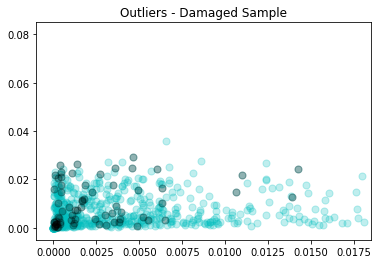

In [34]:
all_fg_indices:np.ndarray = np.ones(D_outlier_scores.shape, dtype=bool)
vis_clusters(D_foreground.T, [all_fg_indices, D_outliers],
             xlim=(-.001, .0185),
             ylim=(-.005, .085),
             title='Outliers - Damaged Sample',
             colors=['c','k'])

# Evaluating outliers over time

**Ground Truth**

Apply a naive zero constant imputation to make time-steps visible and audible

611
[24 37 46 47 68]
[0. 0. 0. 0. 0.]


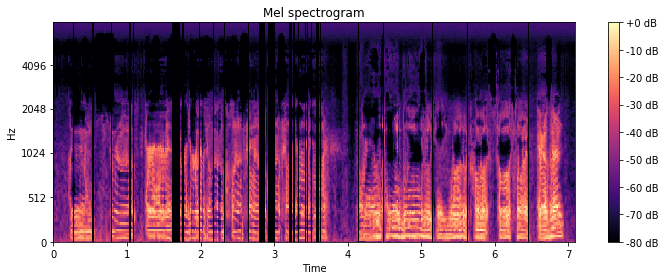

In [35]:
GE = G_foreground.copy()

print(len(G_outlier_scores))
print(G_outliers[:5])

GE.T[G_outliers] = 0
print(GE.T[G_outliers][0][:5])
vis_spec(GE)

In [36]:
sr:int = 44100

In [37]:
GE_audio, GE_with_beeps = audio_with_beeps(GE/G_fg_mask, sr)

In [38]:
IPython.display.Audio(GE_audio, rate=sr) # + E_with_beeps, rate=sr)

Original Reconstructed Ground-Truth Audio

In [39]:
G_audio, G_with_beeps = audio_with_beeps(G_foreground/G_fg_mask, sr)

In [40]:
IPython.display.Audio(G_audio, rate=sr)

Damaged

Replaced Values Sample:  [0. 0. 0. 0. 0.]


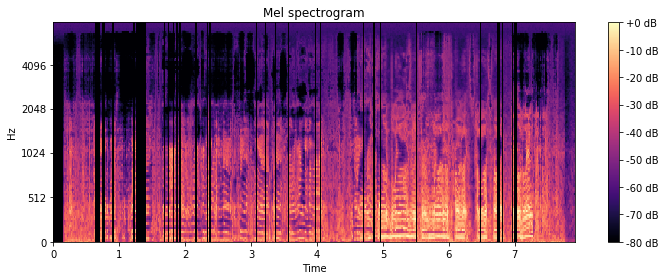

In [41]:
DE = D_foreground.copy()

# zero constant for visibility
DE.T[D_outliers] = 0

print('Replaced Values Sample: ', DE.T[D_outliers][0][:5])

vis_spec(DE)

In [42]:
DE_audio, DE_with_beeps = audio_with_beeps(DE/D_fg_mask, sr)

In [43]:
IPython.display.Audio(DE_audio, rate=sr) # + E_with_beeps, rate=sr)

Original Reconstructed Damaged Audio

In [44]:
D_audio, D_with_beeps = audio_with_beeps(D_foreground/D_fg_mask, sr)

In [45]:
IPython.display.Audio(D_audio, rate=sr)

### Evaluating secondary clusters over time

Ground Truth

In [46]:
# clusters found 
print(np.unique(G_hdb_labels, return_counts=True))

(array([-1,  0,  1,  2,  3]), array([320,  11,  13, 257,  10]))


Zero constant imputation on a cluster

Labels Count:  257
Sample Indices:  [0 1 2 3 4]
Values Max:  0.00026717625
Original Values:  [1.3633264e-04 2.6717625e-04 3.1386517e-05 1.5544060e-06 2.6851408e-06]
Replaced Values:  [0. 0. 0. 0. 0.]


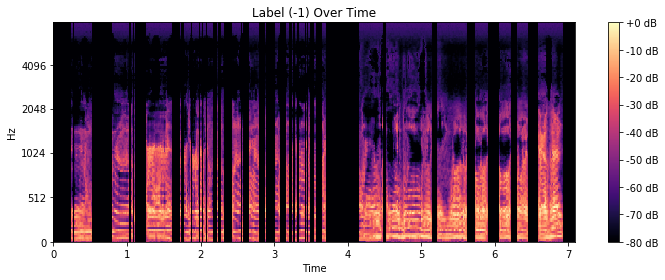

In [47]:
GS = G_foreground.copy()
GS_indices:np.ndarray = np.where(G_hdb_labels == 2)[0]

print('Labels Count: ', len(GS_indices))
print('Sample Indices: ', GS_indices[:5])
print('Values Max: ', G_foreground.T[GS_indices][0][:5].max())

GS.T[GS_indices] = 0

print('Original Values: ', G_foreground.T[GS_indices][0][:5])
print('Replaced Values: ', GS.T[GS_indices][0][:5])

vis_spec(GS, title="Label (-1) Over Time")

Damaged

In [48]:
# clusters found 
print(np.unique(D_hdb_labels, return_counts=True))

(array([-1,  0,  1]), array([144, 529,   9]))


Apply a naive zero constant imputation of cluster values

Labels Count:  144
Sample Indices:  [103 107 108 112 152]
Values Max:  0.083224416
Original Values:  [0.00061457 0.00380886 0.08322442 0.04372566 0.0005275 ]
Replaced Values:  [0. 0. 0. 0. 0.]


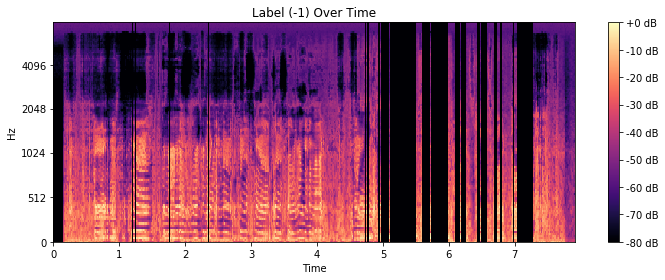

In [49]:
DS = D_foreground.copy()
DS_indices:np.ndarray = np.where(D_hdb_labels == -1)[0]

print('Labels Count: ', len(DS_indices))
print('Sample Indices: ', DS_indices[:5])
print('Values Max: ', D_foreground.T[DS_indices][0][:5].max())

DS.T[DS_indices] = 0

print('Original Values: ', D_foreground.T[DS_indices][0][:5])
print('Replaced Values: ', DS.T[DS_indices][0][:5])

vis_spec(DS, title="Label (-1) Over Time")

In [50]:
DS_audio, DS_with_beeps = audio_with_beeps(DS/D_fg_mask, sr)

In [51]:
IPython.display.Audio(DS_audio, rate=sr)

# Imputing Values

Replicating missing data

In [52]:
DI = D_foreground.copy()

# Replace values with None
DI.T[DS_indices] = None # labels == -1
print("has any nan: ", (np.isnan(DI)).any())
print(DI.T[DS_indices][0])

has any nan:  True
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]


In [53]:
def score_imputer(data, title="Refined Imputation with KNN"):
    try:
        clusterer:Clusterer = Clusterer(data.T, [f'm-{i}' for i in range(0,128)])
        min_cluster_size:int = search_param(clusterer.apply_hdbscan, 
                                            'min_cluster_size', 
                                             mn=2, mx=100, 
                                             params={})
        min_samples:int = search_param(clusterer.apply_hdbscan,
                                           'min_samples', 
                                           mn=2, mx=100,
                                           params={'min_cluster_size': min_cluster_size})
        SilScore:float = clusterer.apply_hdbscan({ # euclidean distance
            'min_cluster_size':min_cluster_size,
            'min_samples': min_samples,
            'allow_single_cluster': True
        })
        labels:tuple = clusterer.hdbscan.labels_
        print('Best K:', len(np.unique(labels)))
        print('Optimal min_cluster_size:', min_cluster_size)
        print('Optimal min_samples:', min_samples)
        print('Labels:', np.unique(labels, return_counts=True))
        print('Silhouette Score:', SilScore)
    except Exception as e:
        print('Clustering failed', e)
    
    vis_spec(data.T, title=title)

### Imputation using Most Frequent

In [54]:
RF = impyute.imputation.cs.mode(DI.copy().T.astype(float))

Best K: 3
Optimal min_cluster_size: 2
Optimal min_samples: 5
Labels: (array([-1,  0,  1]), array([67, 59,  2]))
Silhouette Score: 0.05544756750476724


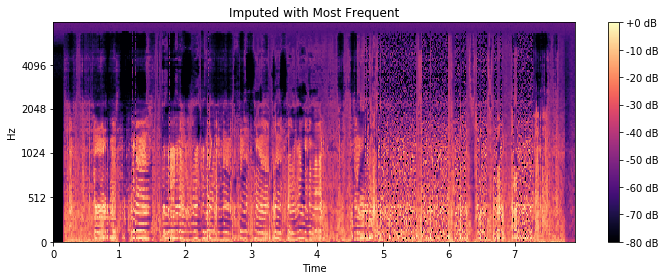

In [55]:
score_imputer(RF, title="Imputed with Most Frequent")

In [56]:
RF_audio, RF_with_beeps = audio_with_beeps(RF.T/D_fg_mask, sr)

In [57]:
IPython.display.Audio(RF_audio, rate=sr)

### Imputation using KNN

In [58]:
RK = impyute.imputation.cs.fast_knn(DI.copy().T.astype(float))

Best K: 18
Optimal min_cluster_size: 2
Optimal min_samples: 2
Labels: (array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16]), array([64,  2,  2,  2,  3,  2,  2,  2,  3,  2,  2,  2,  2,  4,  9,  5,  2,
       18]))
Silhouette Score: -0.13989927076317282


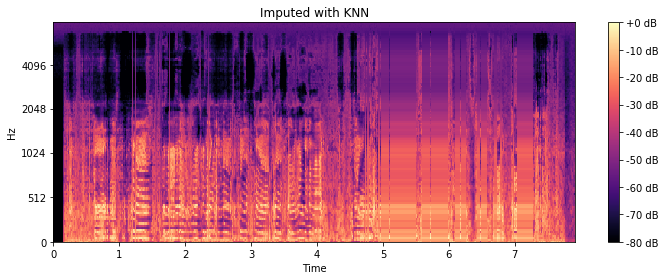

In [59]:
score_imputer(RK, title="Imputed with KNN")

In [60]:
RK_audio, RK_with_beeps = audio_with_beeps(RK.T/D_fg_mask, sr)

In [61]:
IPython.display.Audio(RK_audio, rate=sr)

# Refinement

Best K: 18
Optimal min_cluster_size: 2
Optimal min_samples: 2
Labels: (array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16]), array([64,  2,  2,  2,  3,  2,  2,  2,  3,  2,  2,  2,  2,  4,  9,  5,  2,
       18]))
Silhouette Score: -0.13989927076317282


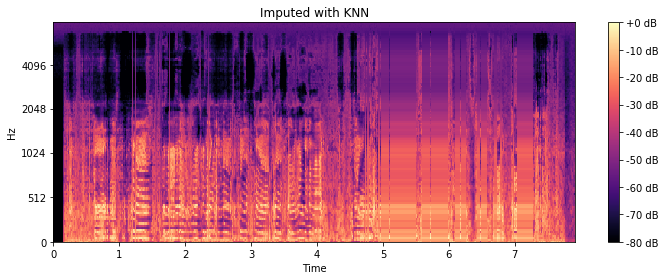

In [62]:
"""
Minkowski P-norm
p1 = Manhattan distance
p2 = Euclidean distance

Epsilon
“Return approximate nearest neighbors; 
the kth returned value is guaranteed 
to be no further than (1+eps) times 
the distance to the real kth nearest neighbor”. 
"""

# Defaults data, k=3, eps=0, p=2, distance_upper_bound=inf, leafsize=10, 
fast_knn = impyute.imputation.cs.fast_knn(DI.copy().T.astype(float), k=4, eps=1, p=2,)
score_imputer(fast_knn, title="Imputed with KNN")

Best K: 12
Optimal min_cluster_size: 2
Optimal min_samples: 2
Labels: (array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([92,  2,  2,  2,  2,  2,  3,  3,  5,  2,  3, 10]))
Silhouette Score: -0.4143044508438093


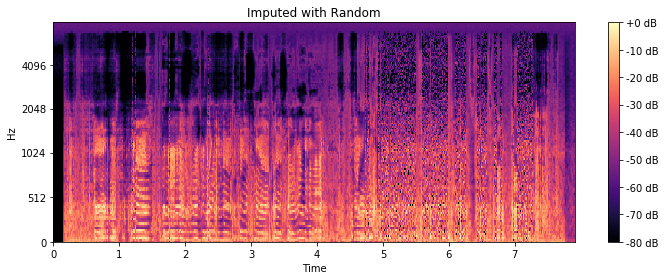

In [63]:
random = impyute.imputation.cs.random(DI.copy().T.astype(float))
score_imputer(random, title="Imputed with Random")

Best K: 14
Optimal min_cluster_size: 2
Optimal min_samples: 2
Labels: (array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), array([81,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2, 22,  2,  3]))
Silhouette Score: -0.3060143602970484


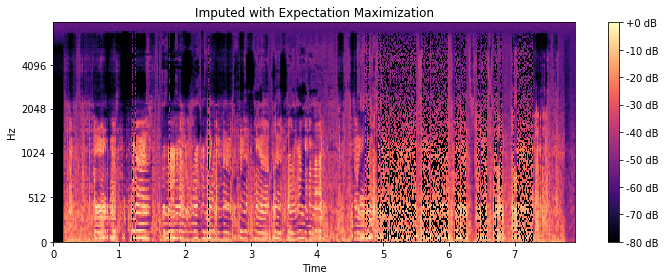

In [64]:
expectation_maximization = impyute.imputation.cs.em(DI.copy().T.astype(float))
score_imputer(expectation_maximization, title="Imputed with Expectation Maximization")

Best K: 18
Optimal min_cluster_size: 2
Optimal min_samples: 2
Labels: (array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16]), array([64,  2,  2,  2,  3,  2,  2,  2,  3,  2,  2,  2,  2,  4,  9,  5,  2,
       18]))
Silhouette Score: -0.14141973499865676


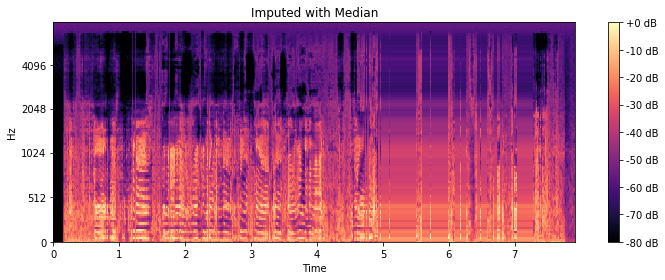

In [65]:
median = impyute.imputation.cs.median(DI.copy().T.astype(float))
score_imputer(median, title="Imputed with Median")

Best K: 18
Optimal min_cluster_size: 2
Optimal min_samples: 2
Labels: (array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16]), array([64,  2,  2,  2,  3,  2,  2,  2,  3,  2,  2,  2,  2,  4,  9,  5,  2,
       18]))
Silhouette Score: -0.13989927076317277


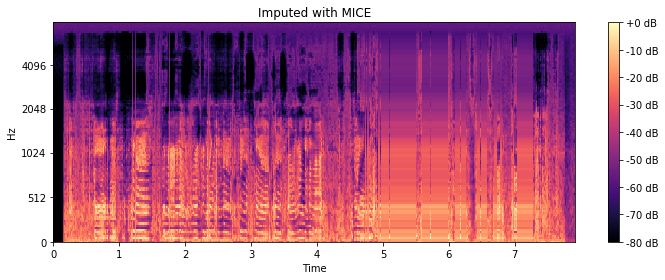

In [66]:
mice = impyute.imputation.cs.mice(DI.copy().T.astype(float))
score_imputer(mice, title="Imputed with MICE")

## Impute with Iterative Imputer

In [67]:
def iterative_impute(fit:np.ndarray, 
                     transform:np.ndarray, 
                     params:dict={}) -> np.ndarray:
    params.update({'random_state':42})
    imp = IterativeImputer(**params)
    imp.fit(fit)  
    return imp.transform(transform)

Best K: 19
Optimal min_cluster_size: 2
Optimal min_samples: 2
Labels: (array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17]), array([60,  2,  2,  2,  5,  2,  2,  2,  2,  3,  2,  2,  2,  2,  4,  9,  5,
        2, 18]))
Silhouette Score: -0.13108974209868374


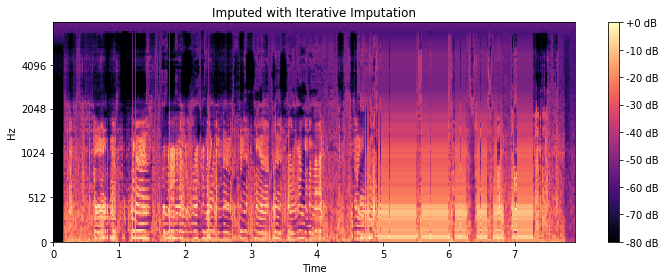

In [68]:
original:np.ndarray = D_foreground.copy().T.astype(float)
missing:np.ndarray = DI.copy().T.astype(float)

params = {
    'max_iter': 20,
    'imputation_order': 'roman', # Left to right.
    'min_value': original.min(),
    'max_value': original.max(),
    'initial_strategy': 'mean',
}
ii = iterative_impute(original, 
                      missing,
                      params, 
                     )

score_imputer(ii, title="Imputed with Iterative Imputation")

In [81]:
final_audio, final_with_beeps = audio_with_beeps(ii.T/D_fg_mask, sr)
# IPython.display.Audio(final_audio, rate=sr)

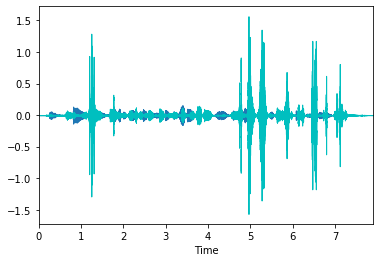

In [87]:
librosa_display.waveplot(G_audio, sr)
librosa_display.waveplot(final_audio, sr, color='c',)

Text(0, 0.5, 'Frequency')

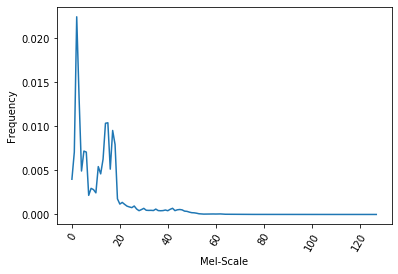

In [80]:
cols = [f'{i}' for i in range(0,128)]
i_sum = pd.DataFrame(ii, columns=cols)[cols].mean()
plt.plot(i_sum)
plt.xticks(np.arange(128, step=20,),rotation=60, fontsize=10)
# plt.xlim(0,60)
plt.xlabel("Mel-Scale")
plt.ylabel("Frequency")